In [1]:
%load_ext autoreload
%autoreload 2

# Needed imports
from abtest import utils # local utils; see utils.py
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Some settings for the notebook
%precision 5
np.set_printoptions(precision=4)
pd.set_option('precision',4)

## Motivations

In an A/B test we observe the behavior of the world (customers) given two different treatments.
Common example is the case where two groups of users are shown two different variants of some web page and their reaction (e.g. subscription rate) is measured.
Ultimately, the question is which variant performs better.
In practice, normally you should assign a variant to each customer randomly, thus split your traffic.
There are many subtle points and issues you should pay attention, but are skipped in this tutorial.
Traditionally, the notions of *control* and *variant* are used where the former is the current implementation of the system and the latter is the new feature/change.

First, to get better intuition, simulate $M$ identical experiments where each variant is shown to $N$ users.

In [2]:
M = 3000 # Number of experiments
N = 2000 # Number of samples per experiment

# For reproducibility, we set a seed which we use to generate seeds 
# for each simulation
np.random.seed(42)
# Generate M seeds, one for each experiment
seeds = np.random.randint(0, 2**32-1, size=(M))

In reality there are three possible case:

* The variant and the control perform the same
* The variant performs better than the control (i.e. you found an improvement)
* The control performs better than the variant (i.e. you found a deterioration)

The key problem is the following:

> The sample for the variant and for the control groups will (almost) always yield one of the last two!

This, in turn, raises the question how can you tell whether your variant had no influence or not, and if it did in which direction.
In what follows, `control_cr` (or $p_c$) and `variant_cr` (or $p_v$) are the *conversion rates* or *proportions* of the control and variant groups, respectively.
From the A/B test, our aim is to learn something about these two numbers.
Start with the same proportion for both groups; that is simulate the case where the variant had no influence.


*Note*: The notions "proportion" and "conversion rate (CR)" are used interchangeably.

In [3]:
control_cr = 0.3 # 30% 
variant_cr = 0.3 # 30%
experiments = [
    utils.generate_experiment(
        seed=seed, N=N, control_cr=control_cr, variant_cr=variant_cr
    ) for seed in seeds]

For each simulation, compute the signed difference between $p_c$ and $p_v$:

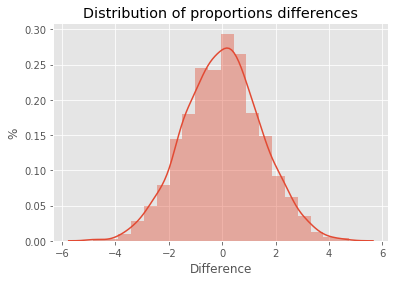

In [4]:
cr_diffs = pd.Series([exp.CR_pct.diff()[-1] for exp in experiments])
sns.distplot(cr_diffs, bins=20, kde=True, rug=False)
plt.title("Distribution of proportions differences")
plt.xlabel('Difference')
plt.ylabel('%');

It comes as no surprise: the difference between the proportions is hardly every zero. 
Following computation counts in how many simulations $$\|p_c - p_v\| < 0.05$$

In [5]:
portion_almost_zero_diff = np.abs(cr_diffs)[np.abs(cr_diffs) < 0.05].shape[0] / M
portion_almost_zero_diff

0.02100

For only {{portion_almost_zero_diff}} of the experiments the difference between $p_c$ and $p_v$ that you witness is smaller than $0.05$.
In other words, for about 98% of the experiments you will witness a larger difference; **even though there is no real one!!**
So, merely comparing the results of a single test doesn't tell you anything.
You will need to employ a more powerful approach.
This approach is called *hypothesis testing*.

## Defining the hypothesis - two sided case

Assume you want to first know whether the proportion in the variant set, $p_c$, is different from the one of the control.
This can, and should, be rigorously defined as follow

$$\begin{align}
H_0:\quad & p_c = p_v \\
H_a:\quad & p_c \neq p_v
\end{align}$$

As you noticed in the examples above, it is almost certain that the proportion you will witness will not be equal.
However, in this settings, you can ask yourself the following question:

> How likely is it to witness even more extreme results? How likely is it that in another experiment you would have $\bar{p}_c$ and $\bar{p}_v$ such that $$\|\bar{p}_c - \bar{p}_v \| \geq \|p_c - p_v\|$$
> assuming that $H_0$ holds

If you could compute this likelihood, and it would be extremely small, you would feel comfortable to *reject* the null hypothesis $H_0$ and accept the alternative one.
To enhance the intuition, you can run a simulation.
First, run a base experiment and record the difference between the proportions.
Next, run $M$ more simulations and compare the differences between the proportions in each of the simulation and the base difference you noted.

`base_exp` will hold the aggregated results of the base experiment.
`base_cr_diff` will hold the absolute difference between the proportions observed in each group

In [6]:
control_cr = 0.3 # 30% 
variant_cr = 0.3 # 30%
base_exp = utils.generate_experiment(seed=1984, N=N, control_cr=control_cr, variant_cr=variant_cr)
base_cr_diff = np.abs(base_exp.CR_pct.diff()[1])
base_cr_diff

1.60000

Next, run $M$ more simulations and count in how many of them you witness a larger difference.
**Note that in all runs you should assume that $H_0$ holds.**
In practice, this means that `control_cr` and `variant_cr` should be the same.

In [7]:
np.random.seed(42)
seeds = np.random.randint(0, 2**32-1, size=(M))
control_cr = 0.3 # 30% 
variant_cr = 0.3 # 30%
experiments = [
    utils.generate_experiment(
        seed=seed, N=N, control_cr=control_cr, variant_cr=variant_cr
    ) for seed in seeds]
cr_diffs = pd.Series([exp.CR_pct.diff()[-1] for exp in experiments])

In [8]:
print(
    "In ~{}% of the simulation the difference between the proportions\n"
    "is at least {:03.3f} (the one in the base experiment)".format(
        np.round(100 * cr_diffs[np.abs(cr_diffs) > base_cr_diff].shape[0] / M, decimals=2),
        base_cr_diff
    ))

In ~26.47% of the simulation the difference between the proportions
is at least 1.600 (the one in the base experiment)


For the random seed $42$, you can see that witnessing a difference of $1.6$ or larger between the proportions is to be expected in roughly $1/4$ of the cases.
Not so extraordinary.

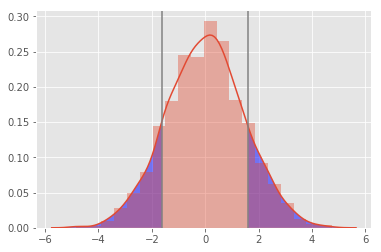

In [9]:
ax = sns.distplot(cr_diffs, bins=20, kde=True, rug=False)
x, y = ax.lines[0].get_data()
mask = (x > base_cr_diff)
x, y = x[mask], y[mask]
ax.fill_between(x, y1=y, alpha=0.5, facecolor='blue')
x, y = ax.lines[0].get_data()
mask = (x < -base_cr_diff)
x, y = x[mask], y[mask]
ax.fill_between(x, y1=y, alpha=0.5, facecolor='blue')
plt.axvline(base_cr_diff, color='gray')
plt.axvline(-base_cr_diff, color='gray');

Now you should change the base experiment, in particular, take different proportions.
This simulates a situation when the variant introduces a change in the proportion.

In [10]:
control_cr = 0.3 # 30% 
variant_cr = 0.32 # 32%
base_exp_2 = utils.generate_experiment(seed=1984, N=N, control_cr=control_cr, variant_cr=variant_cr)
base_2_cr_diff = np.abs(base_exp_2.CR_pct.diff()[1])
base_2_cr_diff

3.65000

Now, have a look in how many cases you witness an even more extreme difference assuming the underlying proportions are the same.

In ~1.03% of the simulation the difference between the proportions
is at least 3.650 (the one in the base experiment)


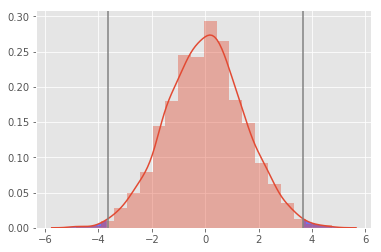

In [11]:
print(
    "In ~{}% of the simulation the difference between the proportions\n"
    "is at least {:03.3f} (the one in the base experiment)".format(
        np.round(100 * cr_diffs[np.abs(cr_diffs) > base_2_cr_diff].shape[0] / M, decimals=2),
        base_2_cr_diff
    ))

ax = sns.distplot(cr_diffs, bins=20, kde=True, rug=False)
x, y = ax.lines[0].get_data()
mask = x > base_2_cr_diff
x, y = x[mask], y[mask]
ax.fill_between(x, y1=y, alpha=0.5, facecolor='blue')
x, y = ax.lines[0].get_data()
mask = x < -base_2_cr_diff
x, y = x[mask], y[mask]
ax.fill_between(x, y1=y, alpha=0.5, facecolor='blue')
plt.axvline(base_2_cr_diff, color='gray')
plt.axvline(-base_2_cr_diff, color='gray');

In the next parts you will learn how to derive similar understandings but using merely the results from a *single* experiment.